In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.optimize

# Ordering rules

- take $\lambda \sim \frac{e^{-\lambda} \lambda^n}{n!}$ with $n = 3$
- compute $68\%$ confidence intervals: central, equal area, and shortest


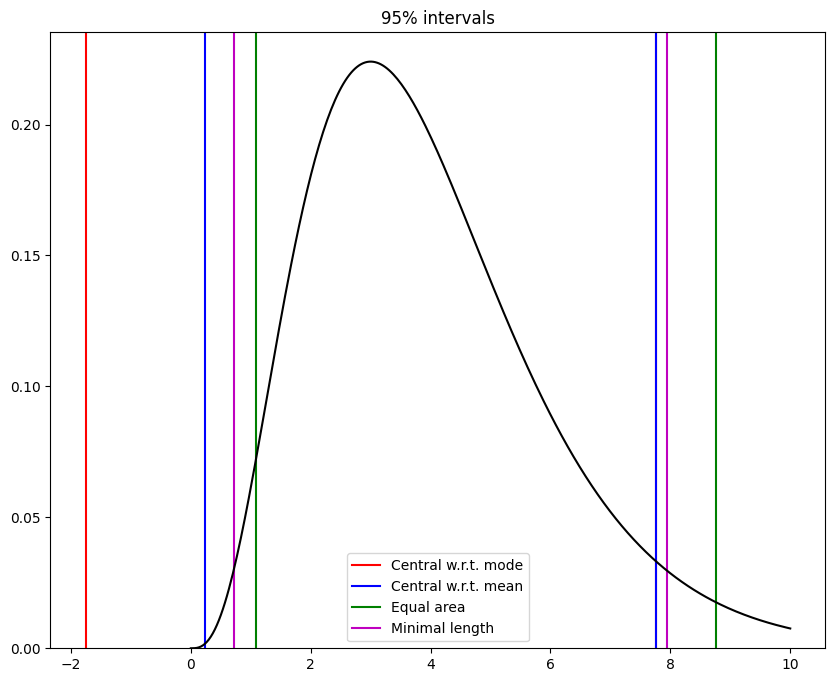

In [72]:
n = 3
beta = 0.95


def log_factorial(n: int) -> int:
    return sum(np.log(i) for i in range(1, n + 1))


def pdf(lmbd: float) -> float:
    if lmbd <= 0:
        return 0
    else:
        return np.exp(-lmbd + n * np.log(lmbd) - log_factorial(n))


intervals: list[tuple[float, float, str, str]] = []

# central interval


def get_central_interval_dbeta(centroid: float):
    def dbeta(halfwidth: float) -> float:
        integral, *_ = scipy.integrate.quad(
            func=pdf, a=centroid - halfwidth, b=centroid + halfwidth
        )
        return integral - beta

    return dbeta


mean, *_ = scipy.integrate.quad(func=lambda x: x * pdf(x), a=-np.inf, b=np.inf)
for centroid, name, color in [
    (n, "mode", "r"),
    (mean, "mean", "b"),
]:
    central_interval_hw = scipy.optimize.newton(get_central_interval_dbeta(centroid), 1)
    intervals.append(
        (
            centroid - central_interval_hw,
            centroid + central_interval_hw,
            f"Central w.r.t. {name}",
            color,
        )
    )


# equal area


def find_quantile(alpha: float) -> float:
    integral_difference = lambda b: alpha - scipy.integrate.quad(pdf, -np.inf, b)[0]
    return scipy.optimize.newton(integral_difference, n)


intervals.append(
    (
        find_quantile(0.5 * (1 - beta)),
        find_quantile(1 - 0.5 * (1 - beta)),
        "Equal area",
        "g",
    )
)


# minimal length
mode = n
pdf_mode = pdf(mode)


def intersections(pdf_level: float) -> tuple[float, float]:
    left = scipy.optimize.newton(lambda x: pdf(x) - pdf_level, mode / 2)
    right = scipy.optimize.newton(lambda x: pdf(x) - pdf_level, 2 * mode)
    return left, right


def dbeta(pdf_level: float) -> float:
    return beta - scipy.integrate.quad(pdf, *intersections(pdf_level))[0]


optimal_pdf_level = scipy.optimize.newton(dbeta, pdf(mode) - 1e-3)
intervals.append((*intersections(optimal_pdf_level), "Minimal length", "m"))


fig, ax = plt.subplots(figsize=(10, 8))

pdf_range = np.linspace(0, 10, 300)

for a, b, label, color in intervals:
    ax.axvline(a, color=color)
    ax.axvline(b, color=color, label=label)

ax.plot(pdf_range, [pdf(l) for l in pdf_range], "k")
ax.legend()
ax.set_title(f"{beta * 100 :.0f}% intervals")
ax.set_ylim(0)
plt.show()